In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import itertools
import warnings
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
warnings.filterwarnings("ignore")

## Diccionario de datos
 
| Variable      |Definición                                                                | ¿Es utilizada? | Entrada/Salida |
|:--------------|:-------------------------------------------------------------------------|:--------------|:----------------|
|  id  |   Número correlativo de vuelos.                   | NO                              | -                             |
|  Airlines  | Nombre abreviado de la aerolinea.                | SI              | ENTRADA                                  |
|   Flight   | Número del vuelo.                            | NO              | -                                   |
|   AirportFrom   | De qué aeropuerto salió el vuelo.                         | Si                 | ENTRADA                         |
|    AirportTo  | A qué aeropuerto llegó el vuelo                 | SI           | ENTRADA                                        |
| DayOfWeek  | Día de la semana del vuelo.                 | SI           | ENTRADA                                                |         
| Time  | Hora de salida expresada en minutos.                  | SI           | ENTRADA                              |
| Length  | Duración del vuelo en minutos.                 | SI           | ENTRADA                              |
| Delay  | Si el vuelo esta demorado.                 | SI           | SALIDA                                      |

## Métricas

En nuestro caso contamos con el set de datos balanceado, por lo que vamos a utilizar como métrica Accuracy. Esta métrica es muy buena para la clacificación cuando el dataset está bien balanceado, evitando problemas como por ejemplo que prediga siempre la misma clase.

Esta métrica nos va a indicar el porcentaje de aciertos que tuvimos.

In [2]:
data=pd.read_csv('Airlines.csv')
data.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [3]:
data.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


## Limpieza y Pre Procesado:

Se eliminan las variables no utilizadas

In [4]:
df = data.drop(['id', 'Flight'],axis=1)
df.head()

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,SFO,IAH,3,15,205,1
1,US,PHX,CLT,3,15,222,1
2,AA,LAX,DFW,3,20,165,1
3,AA,SFO,DFW,3,20,195,1
4,AS,ANC,SEA,3,30,202,0


Se eliminan datos atipicos

In [5]:
df= df.drop(df[(df['Length'] == 0)].index)

In [6]:
df.count()

Airline        539379
AirportFrom    539379
AirportTo      539379
DayOfWeek      539379
Time           539379
Length         539379
Delay          539379
dtype: int64

 ## Feature Engineering

In [7]:
## Funcion que calcula el momento del día
def momento_del_dia(hora):
    if hora >= 360 and hora < 720:
        return 'Mañana' ## MAÑANA
    elif hora >= 720 and hora < 1080:
        return 'Tarde' ## TARDE
    else:
        return 'Noche' ## NOCHE

In [8]:
df['MomentoDelDia'] = df['Time'].apply(momento_del_dia)

In [9]:
mapper = DataFrameMapper([
    (['Airline'], [OneHotEncoder()]),
    (['AirportFrom'], [OneHotEncoder()]),
    (['AirportTo'], [OneHotEncoder()]),
    (['DayOfWeek'], [StandardScaler()]),
    (['Time'], [StandardScaler()]),
    (['Length'], [StandardScaler()]),
    (['MomentoDelDia'], [OneHotEncoder()])
])

## Conjuntos de datos

In [10]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(df, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((323627, 8), (107876, 8), (107876, 8))

In [11]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        #'Precision': [],
        #'Recall': [],
        #'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.Delay
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        #final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        #final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        #final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['No Delay', 'Delay'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))

## Primer modelo: Regresión logística

In [ ]:
parameters = {'penalty': ['none', 'l2']}

clf = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=5, scoring='accuracy')

gs_lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

gs_lr_model.fit(train, train.Delay)

In [ ]:
transformed_data = gs_lr_model.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Cantidad de dimensiones:", dimensiones)

print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

In [ ]:
evaluate_model(gs_lr_model, title='Regresión Logistica', show_cm=True)

### Primer modelo: Regresión logística con PCA

In [ ]:
pca = PCA()

gs_lr_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca), 
])

gs_lr_model_pca.fit(train, train.Delay)

In [ ]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma acumulativa
cumsum = np.cumsum(pca.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} dimensiones, preservamos el {} de la varianza.'.format(d, var_frac))

In [ ]:
parameters = {'penalty': ['none', 'l2']}

pca = PCA(n_components=d)

clf = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=5, scoring='accuracy')

gs_lr_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clf),
    
])

gs_lr_model_pca.fit(train, train.Delay)

In [ ]:
transformed_data = gs_lr_model_pca.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Cantidad de dimensiones:", dimensiones)

print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

In [ ]:
evaluate_model(gs_lr_model_pca, title='Regresión Logistica con PCA', show_cm=True)

## Segundo modelo:  K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
K = 10
parameters = {'n_neighbors': list (range(1, 11))}

clf_knn = GridSearchCV(KNeighborsClassifier(n_neighbors=K), parameters, cv=5, scoring='accuracy')

knn_model = Pipeline([
    ('mapper', mapper),
    ('classifier', clf_knn),
])

In [ ]:
knn_model.fit(train, train.Delay)

In [ ]:
transformed_data = knn_model.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Cantidad de dimensiones:", dimensiones)

print("Cross-Validation Accuracy:", clf_knn.best_score_)
print("Mejores Hiperparametros:", clf_knn.best_params_)

In [ ]:
evaluate_model(knn_model, title='K-NN', show_cm=True)

### Segundo modelo: K-NN con PCA

In [ ]:
pca = PCA()

knn_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca), 
])

knn_model_pca.fit(train, train.Delay)

In [ ]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma acumulativa
cumsum = np.cumsum(pca.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} dimensiones, preservamos el {} de la varianza.'.format(d, var_frac))

In [ ]:
pca = PCA(n_components=d)
K = 10
parameters = {'n_neighbors': list (range(1, 11))}

clf_knn = GridSearchCV(KNeighborsClassifier(n_neighbors=K), parameters, cv=5, scoring='accuracy')

knn_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clf_knn),
])

knn_model_pca.fit(train, train.Delay)

In [ ]:
evaluate_model(knn_model_pca, title='K-NN con PCA', show_cm=True)

## Quinto modelo: Gradient Boosted Trees

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
import graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=mapper.transformed_names_,  
        class_names=['Delay', 'No Delay'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

In [14]:
boost_model = Pipeline([
    ('mapper', mapper),
    ('classifier', GradientBoostingClassifier()),
])

In [15]:
boost_model.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('classifier', GradientBoostingClassifier())])

'Gradient Boosted Trees'

,Accuracy
train,0.649841
validation,0.646900


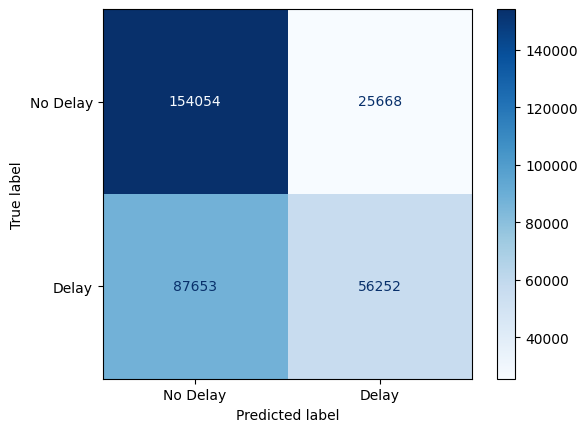

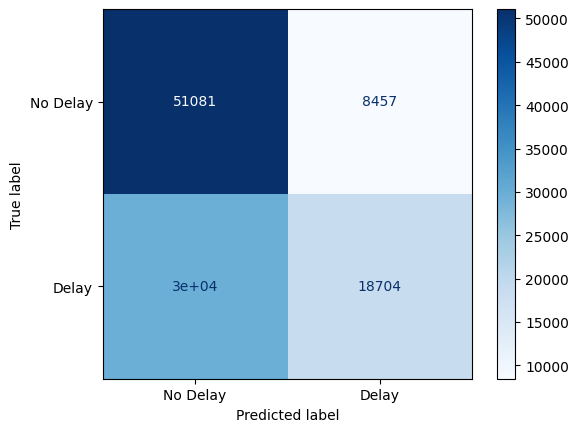

In [16]:
evaluate_model(boost_model, title='Gradient Boosted Trees', show_cm=True)

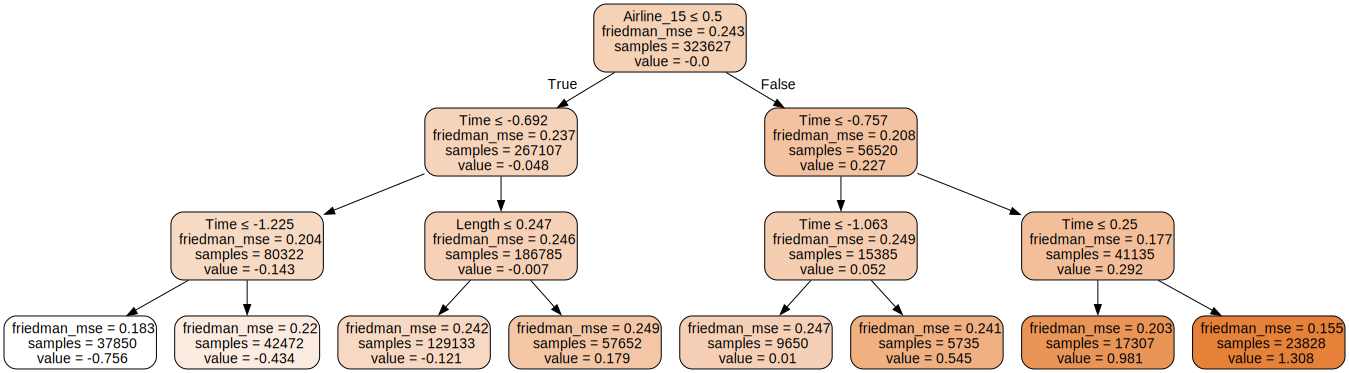

In [24]:
graph_tree(boost_model[1].estimators_[1][0])

### Quinto modelo: Gradient Boosted Trees con PCA

In [25]:
pca = PCA()

gradient_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca), 
])

gradient_model_pca.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('pca', PCA())])

In [26]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma acumulativa
cumsum = np.cumsum(pca.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} dimensiones, preservamos el {} de la varianza.'.format(d, var_frac))

Con 144 dimensiones, preservamos el 0.95 de la varianza.


In [27]:
pca = PCA(n_components=d)

gradient_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', GradientBoostingClassifier()),
])

gradient_model_pca.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('pca', PCA(n_components=144)),
                ('classifier', GradientBoostingClassifier())])

'Gradient Boosted Trees con PCA'

,Accuracy
train,0.656234
validation,0.650951


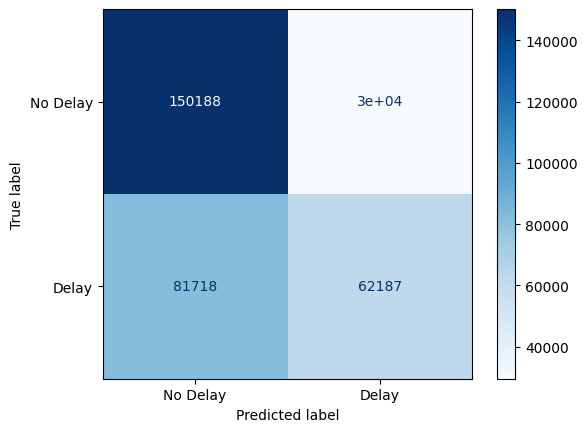

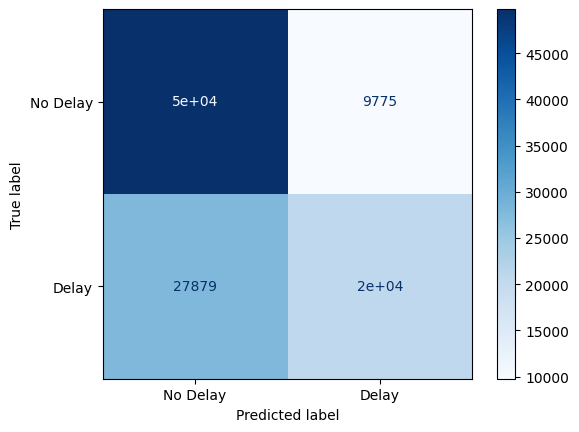

In [28]:
evaluate_model(gradient_model_pca, title='Gradient Boosted Trees con PCA', show_cm=True)